In [1]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 982.9 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 12.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86

# Download Full Dataset

Market-1501 dataset :
https://www.kaggle.com/pengcw1/market-1501

In [2]:
!git clone https://github.com/parth1620/Person-Re-Id-Dataset

Cloning into 'Person-Re-Id-Dataset'...
remote: Enumerating objects: 12942, done.
remote: Counting objects: 100% (12942/12942), done.
remote: Compressing objects: 100% (12942/12942), done.
remote: Total 12942 (delta 0), reused 12942 (delta 0), pack-reused 0
Receiving objects: 100% (12942/12942), 27.68 MiB | 31.01 MiB/s, done.


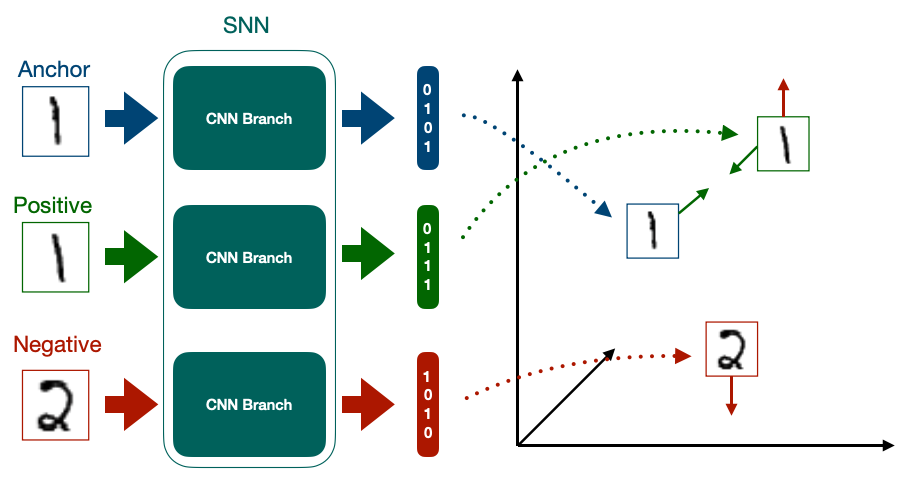

# Imports

In [3]:
import sys
sys.path.append('/content/Person-Re-Id-Dataset')

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import timm

import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset, DataLoader

from skimage import io
from sklearn.model_selection import train_test_split

from tqdm import tqdm

# Configurations

In [5]:
DATA_DIR = '/content/Person-Re-Id-Dataset/train/'
CSV_FILE = '/content/Person-Re-Id-Dataset/train.csv'

BATCH_SIZE = 32
LR = 0.001
EPOCHS = 15

DEVICE = 'cuda'

In [6]:
df = pd.read_csv(CSV_FILE)
df.head()

,Anchor,Negative,Positive
0,1420_c5s3_052165_01.jpg,1334_c6s3_061492_05.jpg,1420_c3s3_051678_01.jpg
1,1420_c3s3_061978_03.jpg,0234_c3s3_079494_02.jpg,1420_c6s3_085567_02.jpg
2,1420_c5s3_062565_05.jpg,0475_c2s1_122816_08.jpg,1420_c3s3_051653_01.jpg
3,1420_c6s3_085592_04.jpg,0662_c2s2_036662_05.jpg,1420_c1s6_013446_04.jpg
4,0663_c5s3_085987_03.jpg,1463_c2s3_098102_02.jpg,0663_c3s3_085544_06.jpg


In [7]:
row = df.iloc[4]

A_img = io.imread(DATA_DIR + row.Anchor)
P_img = io.imread(DATA_DIR + row.Positive)
N_img = io.imread(DATA_DIR + row.Negative)

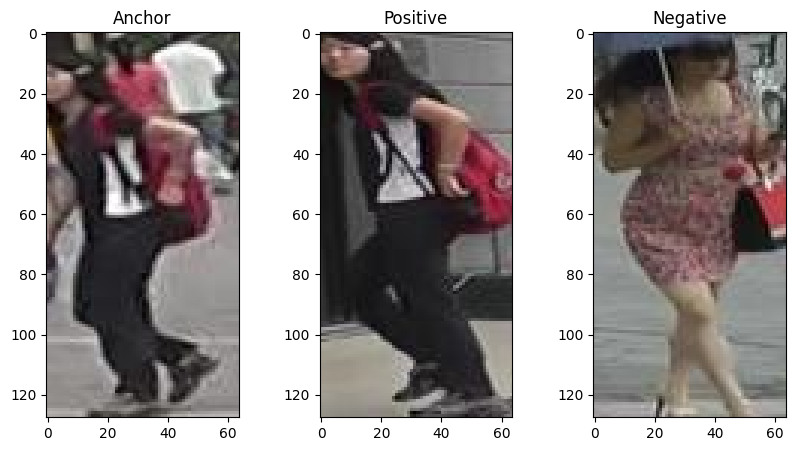

In [8]:
f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (10, 5))

ax1.set_title('Anchor')
ax1.imshow(A_img)

ax2.set_title('Positive')
ax2.imshow(P_img)

ax3.set_title('Negative')
ax3.imshow(N_img)

Train Test Split

In [9]:
train_df, valid_df = train_test_split(df, test_size = 0.20, random_state = 42)

# Create APN Dataset

In [10]:
class APN_Dataset(Dataset):

  def __init__(self, df):
    self.df = df

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    row = self.df.iloc[idx]

    A_img = io.imread(DATA_DIR + row.Anchor)
    P_img = io.imread(DATA_DIR + row.Positive)
    N_img = io.imread(DATA_DIR + row.Negative)

    # Convert to PyTorch vectors and scale to normalize
    A_img = torch.from_numpy(A_img).permute(2, 0, 1) / 255.0
    P_img = torch.from_numpy(P_img).permute(2, 0, 1) / 255.0
    N_img = torch.from_numpy(N_img).permute(2, 0, 1) / 255.0

    return A_img, P_img, N_img

In [11]:
trainset = APN_Dataset(train_df)
validset = APN_Dataset(valid_df)

print(f"Size of trainset : {len(trainset)}")
print(f"Size of validset : {len(validset)}")

Size of trainset : 3200
Size of validset : 800


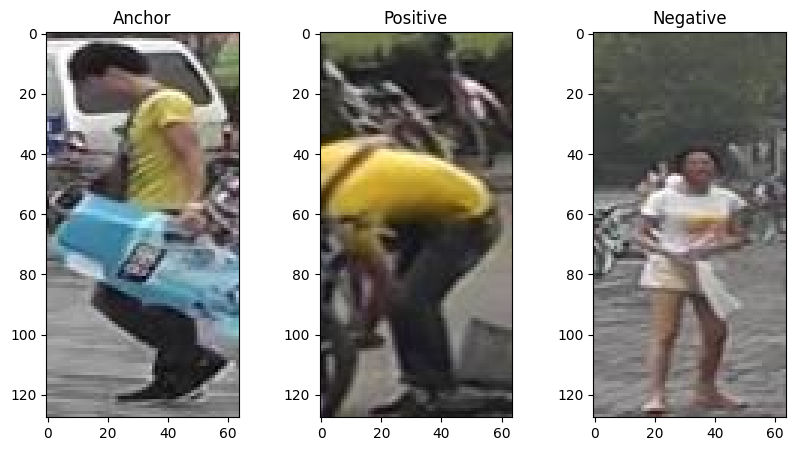

In [12]:
idx = 40
A,P,N = trainset[idx]

f, (ax1, ax2, ax3) = plt.subplots(1,3,figsize= (10,5))

ax1.set_title('Anchor')
ax1.imshow(A.numpy().transpose((1,2,0)), cmap = 'gray')

ax2.set_title('Positive')
ax2.imshow(P.numpy().transpose((1,2,0)), cmap = 'gray')

ax3.set_title('Negative')
ax3.imshow(N.numpy().transpose((1,2,0)), cmap = 'gray')

# Load Dataset into Batches

In [13]:
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True)
validloader = DataLoader(validset, batch_size = BATCH_SIZE)

In [14]:
print(f"No. of batches in trainloader : {len(trainloader)}")
print(f"No. of batches in validloader : {len(validloader)}")

No. of batches in trainloader : 100
No. of batches in validloader : 25


In [15]:
for A, P, N in trainloader:
  break

print(f"One image batch shape : {A.shape}")

One image batch shape : torch.Size([32, 3, 128, 64])


# Create Model

In [19]:
class APN_Model(nn.Module):

  def __init__(self, emb_size = 512):
    super(APN_Model, self).__init__()

    self.efficientnet = timm.create_model('efficientnet_b0', pretrained = True)
    self.efficientnet.classifier = nn.Linear(in_features=self.efficientnet.classifier.in_features, out_features = emb_size)

  def forward(self, images):
    embeddings = self.efficientnet(images)
    return embeddings

In [20]:
model = APN_Model()
model.to(DEVICE)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

APN_Model(
  (efficientnet): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Conv2d(32, 16, kernel_size

# Create Train and Eval function

In [21]:
def train_fn(model, dataloader, optimizer, criterion):

  model.train() # ON Dropout
  total_loss = 0.0

  for A, P, N in tqdm(dataloader):
    A, P, N = A.to(DEVICE), P.to(DEVICE), N.to(DEVICE)

    A_embs = model(A)
    P_embs = model(P)
    N_embs = model(N)

    loss = criterion(A_embs, P_embs, N_embs)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss / len(dataloader)

In [26]:
def eval_fn(model, dataloader, criterion):

  model.train() # ON Dropout
  total_loss = 0.0

  for A, P, N in tqdm(dataloader):
    A, P, N = A.to(DEVICE), P.to(DEVICE), N.to(DEVICE)

    A_embs = model(A)
    P_embs = model(P)
    N_embs = model(N)

    loss = criterion(A_embs, P_embs, N_embs)

    total_loss += loss.item()

  return total_loss / len(dataloader)

In [25]:
criterion = nn.TripletMarginLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

# Create Training Loop

In [28]:
best_valid_loss = np.Inf

for i in range(EPOCHS):

  train_loss = train_fn(model, trainloader, optimizer, criterion)
  valid_loss = eval_fn(model, validloader, criterion)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best_model.pt')
    best_valid_loss = valid_loss
    print('SAVED_WEIGHTS_SUCCESS')

  print(f"EPOCHS : {i+1} train_loss : {train_loss} valid_loss : {valid_loss}")

100%|██████████| 25/25 [00:03<00:00,  6.84it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS : 1 train_loss : 0.5037757641077042 valid_loss : 0.5415304827690125


100%|██████████| 25/25 [00:03<00:00,  6.79it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS : 2 train_loss : 0.3131880521774292 valid_loss : 0.3622352308034897


100%|██████████| 25/25 [00:03<00:00,  6.79it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS : 3 train_loss : 0.15282488644123077 valid_loss : 0.24768110036849975


100%|██████████| 25/25 [00:03<00:00,  6.83it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS : 4 train_loss : 0.07881846114993095 valid_loss : 0.1713838928937912


100%|██████████| 25/25 [00:03<00:00,  6.55it/s]


EPOCHS : 5 train_loss : 0.08118803784251213 valid_loss : 0.17517085373401642


100%|██████████| 25/25 [00:04<00:00,  5.99it/s]


EPOCHS : 6 train_loss : 0.054036269932985305 valid_loss : 0.23540853023529051


100%|██████████| 25/25 [00:04<00:00,  5.43it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS : 7 train_loss : 0.08212296664714813 valid_loss : 0.16292389392852782


100%|██████████| 25/25 [00:04<00:00,  5.37it/s]


EPOCHS : 8 train_loss : 0.04575911343097687 valid_loss : 0.1994137465953827


100%|██████████| 25/25 [00:04<00:00,  6.19it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS : 9 train_loss : 0.053939645141363145 valid_loss : 0.13616753339767457


100%|██████████| 25/25 [00:03<00:00,  6.62it/s]


SAVED_WEIGHTS_SUCCESS
EPOCHS : 10 train_loss : 0.037062536627054214 valid_loss : 0.11312943160533905


100%|██████████| 25/25 [00:03<00:00,  6.68it/s]


EPOCHS : 11 train_loss : 0.031485201865434645 valid_loss : 0.21551961302757264


100%|██████████| 25/25 [00:03<00:00,  6.66it/s]


EPOCHS : 12 train_loss : 0.03507173523306847 valid_loss : 0.19313089907169342


100%|██████████| 25/25 [00:03<00:00,  6.80it/s]


EPOCHS : 13 train_loss : 0.031822194904088975 valid_loss : 0.19240656316280366


100%|██████████| 25/25 [00:03<00:00,  6.71it/s]


EPOCHS : 14 train_loss : 0.06493286877870559 valid_loss : 0.19600312113761903


100%|██████████| 25/25 [00:03<00:00,  6.27it/s]

EPOCHS : 15 train_loss : 0.03285487711429596 valid_loss : 0.23629129946231842


# Get Anchor Embeddings

In [31]:
def get_encoding_csv(model, anc_img_names):
  anc_img_names_arr = np.array(anc_img_names)
  encodings = []

  model.eval()
  with torch.no_grad():
    for i in tqdm(anc_img_names_arr):
      A = io.imread(DATA_DIR + i)
      A = torch.from_numpy(A).permute(2, 0, 1) / 255.0
      A = A.to(DEVICE)
      A_enc = model(A.unsqueeze(0)) #(c, h, w) -> (batch size = 1, c, h, w)
      encodings.append(A_enc.squeeze().cpu().detach().numpy())

    encodings = np.array(encodings)
    encodings = pd.DataFrame(encodings)
    df_enc = pd.concat([anc_img_names, encodings], axis = 1)

  return df_enc

In [32]:
model.load_state_dict(torch.load('best_model.pt'))
df_enc = get_encoding_csv(model, df['Anchor'])

100%|██████████| 4000/4000 [01:03<00:00, 62.65it/s]


In [33]:
df_enc.to_csv('database.csv', index = False)
df_enc.head()

# Results in feature vectors of size encoding_size

,Anchor,0,1,2,3,4,5,6,7,8,...,502,503,504,505,506,507,508,509,510,511
0,1420_c5s3_052165_01.jpg,-0.556760,0.168660,0.283027,-0.372440,0.091271,0.982804,0.712577,-0.050557,0.035195,...,-0.207158,0.844123,-1.387225,0.587867,0.441031,0.184859,-0.040797,0.024941,0.311280,0.679448
1,1420_c3s3_061978_03.jpg,-0.533996,0.143107,0.527479,-0.891446,0.108873,1.051354,0.743917,-0.226195,0.334224,...,-0.183021,1.232808,-1.396114,0.827806,0.919711,0.060779,0.168973,0.050840,1.056532,0.787709
2,1420_c5s3_062565_05.jpg,-0.486818,-0.335803,0.487848,-0.619652,-0.273987,1.187924,0.977503,0.103028,0.069704,...,-0.279945,0.813244,-1.535467,0.891678,0.853549,0.403411,0.130783,0.257837,0.574604,0.725015
3,1420_c6s3_085592_04.jpg,-0.676399,0.628312,0.061512,-0.215208,0.800329,0.591693,0.088018,0.103125,0.459861,...,0.178925,0.493789,-0.854252,0.345534,-0.358655,0.457269,0.026023,-0.050675,0.036918,0.743296
4,0663_c5s3_085987_03.jpg,0.610191,-1.099714,-0.146837,1.026261,-1.798618,-0.356368,-0.402907,1.017758,-0.266827,...,0.351621,-1.233098,0.088206,-0.007492,-0.771767,-0.470970,0.318708,0.225166,-1.466175,-0.906698


# Inference

In [36]:
def euclidean_dist(img_enc, anc_enc_arr):
  dist = np.sqrt(np.dot(img_enc - anc_enc_arr, (img_enc - anc_enc_arr).T))
  return dist

In [38]:
# Get encodings of the first image in the dataframe
idx = 0
img_name = df_enc['Anchor'].iloc[idx]
img_path = DATA_DIR + img_name

img = io.imread(img_path)
img = torch.from_numpy(img).permute(2, 0, 1) / 255.0

model.eval()
with torch.no_grad():
  img = img.to(DEVICE)
  img_enc = model(img.unsqueeze(0))
  img_enc = img_enc.detach().cpu().numpy()

In [41]:
anc_enc_arr = df_enc.iloc[:, 1:].to_numpy()
anc_img_names = df_enc['Anchor']

In [43]:
distance = []

for i in range(anc_enc_arr.shape[0]):
  dist = euclidean_dist(img_enc, anc_enc_arr[i:i+1, :])
  distance = np.append(distance, dist)

In [44]:
closest_idx = np.argsort(distance)

/usr/local/lib/python3.10/dist-packages/networkx/drawing/layout.py:725: RuntimeWarning: divide by zero encountered in divide
  costargs = (np, 1 / (dist_mtx + np.eye(dist_mtx.shape[0]) * 1e-3), meanwt, dim)


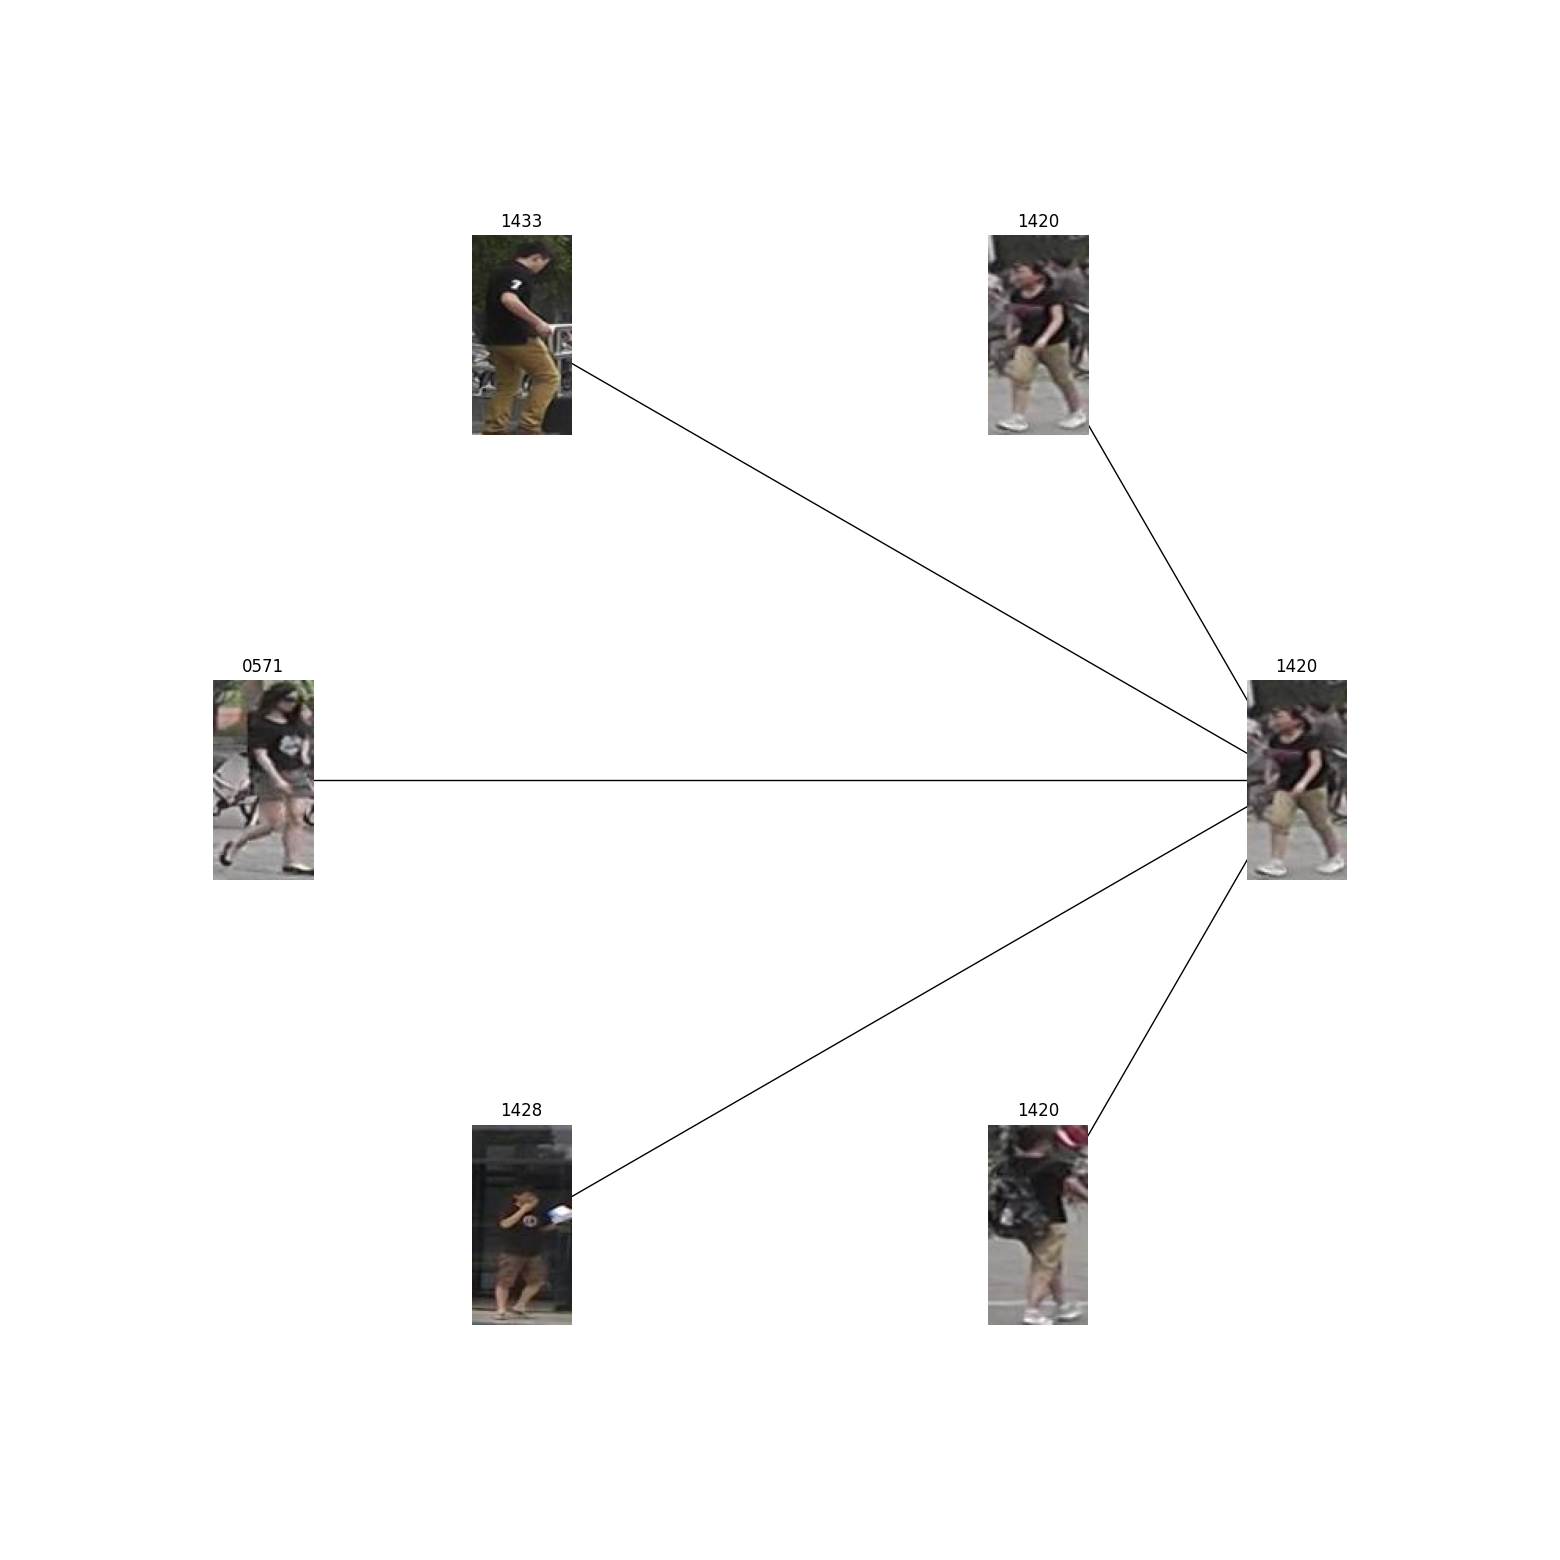

In [45]:
from utils import plot_closest_imgs

plot_closest_imgs(anc_img_names, DATA_DIR, img, img_path, closest_idx, distance, no_of_closest = 5);